Accessing data with Python
===

## Packages used
To use python to access the ERDDAP server directly from your python script or jupyter-notebook, you will need
- Xarray
- netcdf4 
- matplotlib
- folium

:::{admonition} Packages
The package [**netcdf4**](http://unidata.github.io/netcdf4-python/) develop by UNIDATA is not needed in the import part of the python script. However, it is the essential package that [support netCDF format output from Xarray and OPeNDAP access](https://docs.xarray.dev/en/stable/user-guide/io.html). The package [**matplotlib**](https://matplotlib.org/stable/) is also not needed in the import part of the python script. It is the essential package that [support quick visualization from Xarray](https://docs.xarray.dev/en/stable/user-guide/plotting.html).
:::

---

On this page, we will explore the process of extracting a subset of model simualtion data produce from the regional MOM6 model. The model output is to support the Climate Ecosystem and Fishery Initiative. We will showcase how to utilize OPeNDAP for accessing the data and visualize it on an interactive map. The currently available data can be viewed [here](https://psl.noaa.gov/thredds/catalog/Projects/CEFI/regional_mom6/catalog.html). The contents of this folder encompass historical simulations derived from the regional MOM6 model spanning the years 1993 to 2019.

## Import python packages

In [2]:
import xarray as xr

:::{admonition} Info
Thanks to the netCDF4/Pydap library, accessing data through OPeNDAP directly from Xarray is made seamless. For detailed usage guidance, the [Xarray documentation](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap) offers excellent examples and explanations. Ex: if the OPeNDAP server require authentication, `backends.PydapDataStore` can help on storing the login data.
:::

## Access data (regular grid product)

From the previous page explaining [OPeNDAP interface](opendapData), we know that the OPeNDAP URL can be obtained from the form. In our case, we will get the URL from this [form](https://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/hist_run/ocean_monthly.199301-201912.ssh.nc.html)

In [5]:
opendap_url = "http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/hist_run/regrid/ocean_monthly.199301-201912.ssh.nc"
ds_ssh = xr.open_dataset(opendap_url)

In [6]:
ds_ssh

<xarray.Dataset>
Dimensions:  (lon: 774, lat: 844, time: 325)
Coordinates:
  * lon      (lon) float64 261.6 261.6 261.7 261.8 ... 323.7 323.8 323.8 323.9
  * lat      (lat) float64 5.273 5.335 5.398 5.461 ... 57.97 58.04 58.1 58.16
  * time     (time) datetime64[ns] 1980-01-01 ... 2019-12-16T12:00:00
Data variables:
    ssh      (time, lat, lon) float32 ...
Attributes:
    NumFilesInSet:       1
    title:               NWA12_COBALT_2023_04_kpo4-coastatten-physics
    associated_files:    areacello: 19930101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello
    history:             Derived and written at NOAA Physical Science Laboratory
    NCO:                 netCDF Operators version 5.0.1 (Homepage = http://nc...
    contact:             chia-wei.hsu@noaa.gov
    dataset:             regional mom6 regrid
    _NCProperties:       version=2,netcdf=4.8.1,hdf5=1.12.2

:::{admonition} Tip
:class: tip
When we use `xr.open_dataset()` to load the data from OPeNDAP, we actually only load the metadata and coordinates information. This provide a great way to peek at the data’s dimension and availability on our local machine in the xarray object format. The actual gridded data values at each grid point will only be downloaded from the PSL server when we add `.load()` to the dataset. 
:::

Since most OPeNDAP server will set a single time data transfer limit (PSL server has a 500MB limit), we cannot `ds_ssh.load()` the whole dataset. However, we can load the sea level map at a single time step which is smaller than 500MB. 

In [27]:
ds_ssh_subset = ds_ssh.sel(time='2012-12').load()

In [28]:
ds_ssh_subset

<xarray.Dataset>
Dimensions:  (lon: 774, lat: 844, time: 1)
Coordinates:
  * lon      (lon) float64 261.6 261.6 261.7 261.8 ... 323.7 323.8 323.8 323.9
  * lat      (lat) float64 5.273 5.335 5.398 5.461 ... 57.97 58.04 58.1 58.16
  * time     (time) datetime64[ns] 2012-12-16T12:00:00
Data variables:
    ssh      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    NumFilesInSet:       1
    title:               NWA12_COBALT_2023_04_kpo4-coastatten-physics
    associated_files:    areacello: 19930101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello
    history:             Derived and written at NOAA Physical Science Laboratory
    NCO:                 netCDF Operators version 5.0.1 (Homepage = http://nc...
    contact:             chia-wei.hsu@noaa.gov
    dataset:             regional mom6 regrid
    _NCProperties:       version=2,netcdf=4.8.1,hdf5=1.12.2

From the xarray dataset object output above, we will notice the `ssh` value in `ds_ssh_subset` is now avaible and printed out while the `ssh` value in `ds_ssh` is not. This means the `ssh` values has been downloaded from the OPeNDAP server to the local machine memory.

## Quick view of the variable

To check if the data makes sense and fits the chosen time and region, you can use Xarray's `.plot()` method. This way, you see a graph instead of just numbers, making it easier to understand.

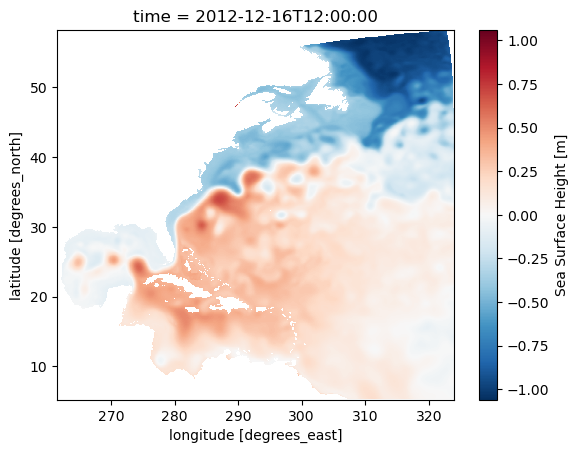

In [11]:
ds_ssh_subset.ssh.plot()

:::{admonition} Science info
:class: info
The map illustrates a clear distinction between high sea levels, primarily from tropical regions (hot and fresh water), and low sea levels, mainly from the Labrador Sea or other polar areas (cold and salty sea water). The meandering pattern of the sharp sea level gradient, indicating rapid sea level changes over a short distance, highlights the location of the Gulf Stream. This distinctive sea level feature is a result of the existence of western boundary currents, commonly observed on the western edges of major ocean basins, such as the Kuroshio in the Pacific basin.
:::

## Plotting the data on a interactive leaflet map
In this section, there are more detail figure manipulation to produce the map shown above and be able to zoom in and out from a interactive map. This is not neccessary for data downloading and preprocessing. However, this shows how the map on the CEFI portal is generated. 

### Load package for the interactive map
- `matplotlib` to generate the color shaded map above 
- `folium` the python interface of generating a leaflet interactive map
- `branca` the colorbar module included when installing folium package

In [12]:
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm

### Specify figure setup

In [13]:
# figure setting
colormap_name = 'RdBu_r'              # colormap name in matplotlib colormap blue to red
n_increments = 20                     # number of increment in the colormap
varmin = -1                           # minimum value on the colorbar
varmax = 1                            # maximum value on the colorbar
varname = 'Sea Surface Height'        # legend show on map
da_regrid_data = ds_ssh_subset['ssh'] # Xarray DataArray object used to plot the map

### Create RGBA code for each grid point
This part use the `matplotlib` to create a special map (2D) which assigns a RGBA code (an array of four number) for each grid point.
This will create a array with the size of `[nlon,nlat,4]`.

In [30]:
# setup the colormap from matplotlib
picked_cm = plt.get_cmap(colormap_name, n_increments)
# normalized data (0,1) for colormap to applied on 
normed_data = (da_regrid_data - varmin) / (varmax - varmin)
colored_data = picked_cm(normed_data.data[0,:,:])


In [31]:
colored_data.shape

(844, 774, 4)

### Start the base map from folium

In [16]:
# folium map base map
fm = folium.Map(
    location=[float(da_regrid_data.lat.mean().data), float(da_regrid_data.lon.mean().data)],
    tiles="Cartodb Positron",
    zoom_start=3
)


### Overlay the colored data on the map

In [32]:
folium.raster_layers.ImageOverlay(
    image=colored_data,
    bounds=[[float(da_regrid_data.lat.min().data),
             float(da_regrid_data.lon.min().data)],
            [float(da_regrid_data.lat.max().data),
             float(da_regrid_data.lon.max().data)]],
    mercator_project=True,   # applied data to web mercator projection (essential)
    origin="lower",          # plot data from lower bound (essential)
    opacity=1,
    zindex=1
).add_to(fm)


### Create the colorbar for the interactive map

In [34]:
import numpy as np
tick_inc = np.abs(varmax-varmin)/10.

# start constructing the branca colormap to put on folium map
index_list = range(0,n_increments)    
cmap_list = picked_cm(range(n_increments)).tolist()
cmap_foliump = cm.LinearColormap(
    colors=cmap_list,
    vmin=varmin,
    vmax=varmax,
    caption='fcmap',
    max_labels=n_increments+1,
    tick_labels=list(np.arange(varmin,varmax+tick_inc*0.000001,tick_inc))
).to_step(n_increments)

# Add the colormap to the folium map
cmap_foliump.caption = varname
cmap_foliump.add_to(fm)


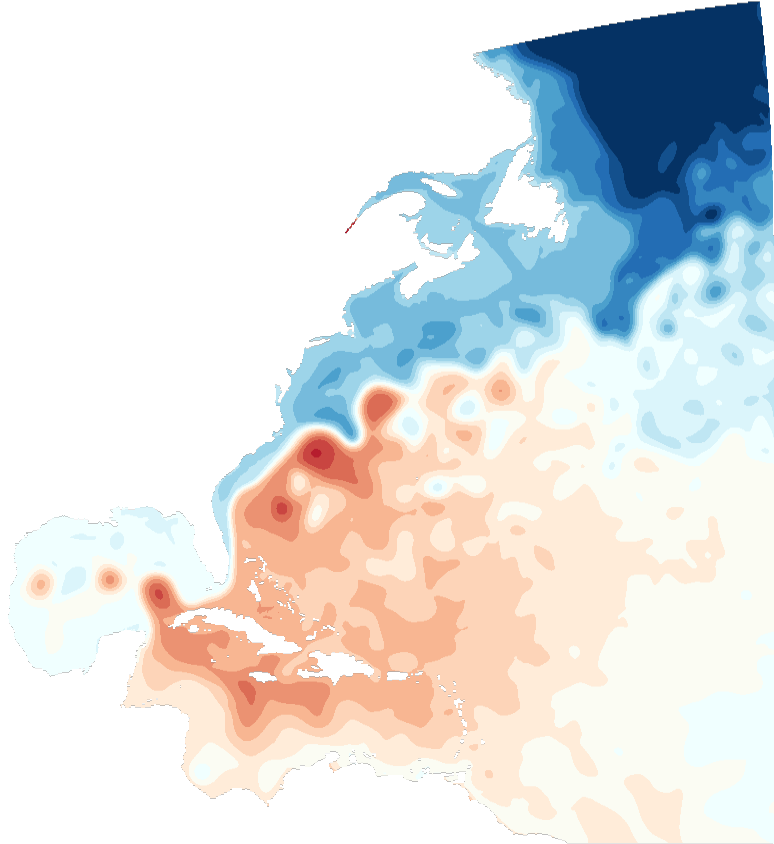

In [35]:
fm

## Access data (raw grid product) 

The raw grid product differs from the regular grid in that it represents the original output of the model. The model grid uses the Arakawa C grid. The [MOM6 documentation](https://mom6.readthedocs.io/en/main/api/generated/pages/Discrete_Grids.html?highlight=arakawa#vertical-grids) provides an excellent visualization of the Arakawa C grid. We can concentrate on the `h` point, which is where scalar values like sea level height are stored. The grid does not have uniform spacing and is, in fact, a curvilinear grid.

:::{admonition} Info
The raw model output is beneficial when calculating the energy budget, which includes factors like heat and momentum. This output preserves each term's original values, avoiding any potential distortions caused by interpolation. By using the raw grid product, we can ensure the energy budget balances within a closed system.
:::


To use the raw grid data, one need to get two files. 
1. the variable file
2. the static file

In [9]:
opendap_url = "http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/hist_run/ocean_monthly.199301-201912.ssh.nc"
ds_ssh = xr.open_dataset(opendap_url)

opendap_static_url = "http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/hist_run/ocean_static.nc"
ds_static = xr.open_dataset(opendap_static_url)

In [6]:
ds_ssh

<xarray.Dataset> Size: 849MB
Dimensions:     (time: 324, nv: 2, xh: 775, yh: 845)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
  * time        (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-16T...
  * xh          (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh          (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
Data variables:
    average_DT  (time) timedelta64[ns] 3kB ...
    average_T1  (time) datetime64[ns] 3kB ...
    average_T2  (time) datetime64[ns] 3kB ...
    ssh         (time, yh, xh) float32 849MB ...
    time_bnds   (time, nv) datetime64[ns] 5kB ...
Attributes:
    NumFilesInSet:                   1
    title:                           NWA12_COBALT_2023_04_kpo4-coastatten-phy...
    associated_files:                areacello: 19930101.ocean_static.nc
    grid_type:                       regular
    grid_tile:                       N/A
    external_variables:              areacello
    history:                         Fri May 12 10:49:27 2023: ncks -4 -L 3 o...
    NCO:                             netCDF Operators version 5.0.1 (Homepage...
    _NCProperties:                   version=2,netcdf=4.9.0,hdf5=1.12.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [7]:
ds_static

<xarray.Dataset> Size: 66MB
Dimensions:       (time: 1, xh: 775, xq: 776, yh: 845, yq: 846)
Coordinates:
  * time          (time) datetime64[ns] 8B 1980-01-01
  * xh            (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * xq            (xq) float64 6kB -98.04 -97.96 -97.88 ... -36.2 -36.12 -36.04
  * yh            (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
  * yq            (yq) float64 7kB 5.233 5.312 5.392 5.472 ... 51.9 51.92 51.94
Data variables: (12/25)
    Coriolis      (yq, xq) float32 3MB ...
    areacello     (yh, xh) float32 3MB ...
    areacello_bu  (yq, xq) float32 3MB ...
    areacello_cu  (yh, xq) float32 3MB ...
    areacello_cv  (yq, xh) float32 3MB ...
    deptho        (yh, xh) float32 3MB ...
    ...            ...
    geolon_v      (yq, xh) float32 3MB ...
    sftof         (yh, xh) float32 3MB ...
    wet           (yh, xh) float32 3MB ...
    wet_c         (yq, xq) float32 3MB ...
    wet_u         (yh, xq) float32 3MB ...
    wet_v         (yq, xh) float32 3MB ...
Attributes:
    _NCProperties:                   version=2,netcdf=4.9.0,hdf5=1.12.2
    NumFilesInSet:                   1
    title:                           NWA12_MOM6_v1.0
    grid_type:                       regular
    grid_tile:                       N/A
    history:                         Fri May 12 10:50:21 2023: ncks -4 -L 3 o...
    NCO:                             netCDF Operators version 5.0.1 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

:::{admonition} Tip
:class: tip
Again, only the metadata and coordinate information are loaded into local memory, not the actual data. The gridded data values at each grid point are only downloaded from the PSL server when we append `.load()` to the dataset.
:::



:::{admonition} Warning
:class: tip
In the `ds_static` dataset, you can observe the one-dimensional `xh, yh` grid. The numbers on this grid may resemble longitude and latitude values, but they do not represent actual geographical locations. For accurate longitude and latitude data, you should refer to the `geolon, geolat` variables in the list. These variables, which are dimensioned by `xh, yh`, provide the correct geographical coordinates.
:::

Now let's take a look at the grid area distribution which give a great sense of how it is different from regular spacing grid

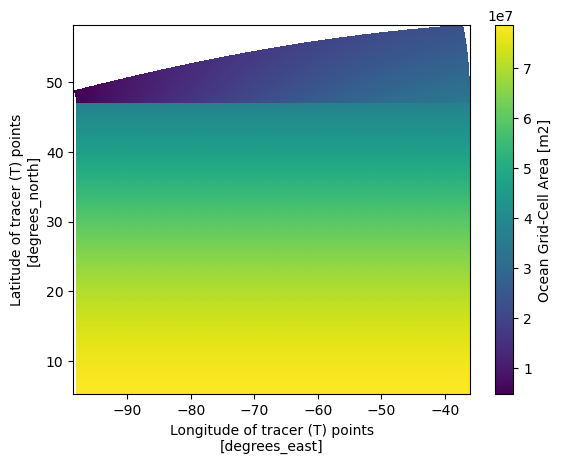

In [13]:
ds_static = ds_static.set_coords(['geolon','geolat'])
ds_static.areacello.plot(x='geolon',y='geolat')

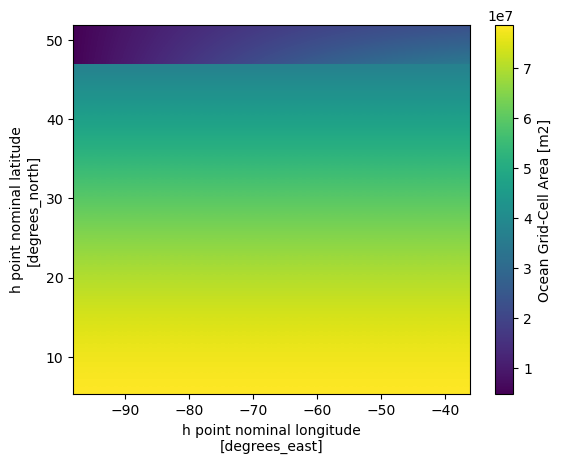

In [14]:
ds_static.areacello.plot(x='xh',y='yh')

We can see that the most significant differences between the two maps are located in the higher latitudes. Since the grid information is important in the raw grid, the easiest way to merge the two dataset so we can have the accurate lon lat that follows the data that we are going to work on.

In [18]:
ds_ssh_subset = ds_ssh.sel(time='2012-12').load()
ds = xr.merge([ds_ssh_subset,ds_static])
ds = ds.isel(time=slice(1,None))  # exclude the 1980 empty field due to merge


In [19]:
ds

<xarray.Dataset> Size: 68MB
Dimensions:       (nv: 2, time: 1, xh: 775, yh: 845, xq: 776, yq: 846)
Coordinates:
  * nv            (nv) float64 16B 1.0 2.0
  * time          (time) datetime64[ns] 8B 2012-12-16T12:00:00
  * xh            (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh            (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
  * xq            (xq) float64 6kB -98.04 -97.96 -97.88 ... -36.2 -36.12 -36.04
  * yq            (yq) float64 7kB 5.233 5.312 5.392 5.472 ... 51.9 51.92 51.94
    geolat        (yh, xh) float32 3MB ...
    geolon        (yh, xh) float32 3MB ...
Data variables: (12/28)
    average_DT    (time) timedelta64[ns] 8B 31 days
    average_T1    (time) datetime64[ns] 8B 2012-12-01
    average_T2    (time) datetime64[ns] 8B 2013-01-01
    ssh           (time, yh, xh) float32 3MB nan nan nan ... -0.9031 -0.9001
    time_bnds     (time, nv) datetime64[ns] 16B 2012-12-01 2013-01-01
    Coriolis      (yq, xq) float32 3MB ...
    ...            ...
    geolon_v      (yq, xh) float32 3MB ...
    sftof         (yh, xh) float32 3MB ...
    wet           (yh, xh) float32 3MB ...
    wet_c         (yq, xq) float32 3MB ...
    wet_u         (yh, xq) float32 3MB ...
    wet_v         (yq, xh) float32 3MB ...
Attributes:
    NumFilesInSet:                   1
    title:                           NWA12_COBALT_2023_04_kpo4-coastatten-phy...
    associated_files:                areacello: 19930101.ocean_static.nc
    grid_type:                       regular
    grid_tile:                       N/A
    external_variables:              areacello
    history:                         Fri May 12 10:49:27 2023: ncks -4 -L 3 o...
    NCO:                             netCDF Operators version 5.0.1 (Homepage...
    _NCProperties:                   version=2,netcdf=4.9.0,hdf5=1.12.2
    DODS_EXTRA.Unlimited_Dimension:  time

From the xarray dataset object output above, we will notice the `ssh` value in `ds` is now avaible and the coordinate information in teh coordinate is also include into a single Dataset object.

## Quick view of the variable

To check if the data makes sense and fits the chosen time and region, you can use Xarray's `.plot()` method. This way, you see a graph instead of just numbers, making it easier to understand.

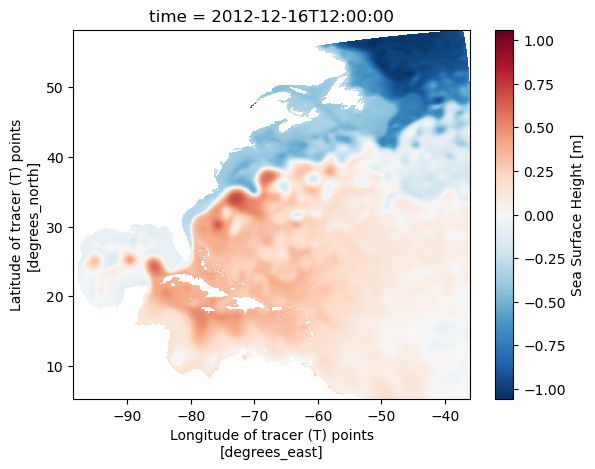

In [20]:
ds.ssh.plot(x='geolon',y='geolat')